### Problem Description

Write some details of the problem ... also mention the link of the dataset

In [51]:
pip install -U gensim

Requirement already up-to-date: gensim in c:\programdata\anaconda3\lib\site-packages (4.0.1)
Note: you may need to restart the kernel to use updated packages.


In [89]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ELFAT7\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [135]:
 nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ELFAT7\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

### Import Packages

In [3]:

# Add environment Packages paths to conda
import os, sys
# env_name = "food_review"
# sys.path.append(f"C:\\Environments\\{env_name}\\lib\\site-packages\\")

import pandas as pd
import numpy as np

# Text preprocessing packages
import nltk # Text libarary
# nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import string # Removing special characters {#, @, ...}
import re # Regex Package
from nltk.corpus import stopwords # Stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer # Stemmer & Lemmatizer
from gensim.utils import simple_preprocess  # Text ==> List of Tokens

# Text Embedding
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Saving Model
import pickle

# Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ELFAT7\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Read Dataset

In [4]:
%%time
df = pd.read_csv('data2.csv')

Wall time: 5.22 s


In [5]:
f"{df.shape[0]:,} Review"

'568,454 Review'

In [6]:
cols = ['Text', 'Score']
df_text = df[cols].copy()
df_text.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


### Drop Duplicates
Save the Cleaned data-frame also with the variable `df_text`

In [7]:
df_text=df_text.reset_index(drop=True)

In [8]:
df_text.sample()

,Text,Score
50920,"Sure it costs a bit more, but all five (yes, c...",5


### Target Variable Pre-Processing
`target` will be 
 - 0 if score < 3 
 - 1 otherwise

In [9]:
df_text['target'] = [0 if score<3 else 1 for score in df_text.Score]
df_text.head()

,Text,Score,target
0,I have bought several of the Vitality canned d...,5,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,0
2,This is a confection that has been around a fe...,4,1
3,If you are looking for the secret ingredient i...,2,0
4,Great taffy at a great price. There was a wid...,5,1


#### Plot Countplot for target Variable

<AxesSubplot:xlabel='target', ylabel='count'>

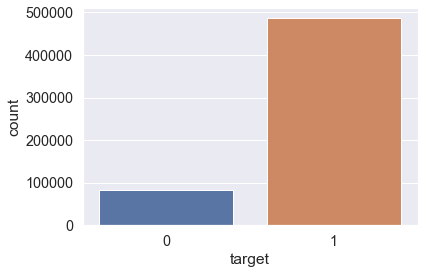

In [10]:
sns.countplot(x="target",data=df_text)

## Write your code here

Notice how such variance is huge ...   
Then we need to down-sample such data ... by which both the positive and negative classes are balanced.

### Balance Data Target

In [11]:
# Sample from positive reviews Same number of negative reviews
NEG_N = df_text.target.value_counts()[0]
df_pos = df_text[df_text['target'] == 1]['Text'].sample(NEG_N, replace=False)
df_text_balanced = pd.concat([df_text.iloc[df_pos.index], df_text[df_text.target == 0]])



<AxesSubplot:xlabel='target', ylabel='count'>

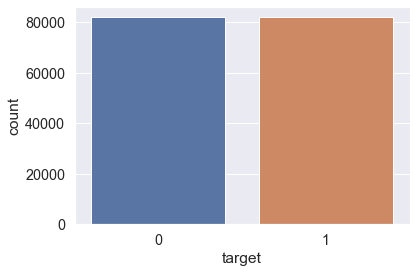

In [12]:
## PLot the target again after balancing
sns.countplot(x="target",data=df_text_balanced)
## Write your code here

### Text Pre-Processing

In [13]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
lemmatizer= WordNetLemmatizer()


In [17]:
df_text_balanced["Text"] = df_text_balanced["Text"].str.lower().apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem)).apply(lambda elem: re.sub(r"\d+", "", elem))
df_text_balanced.head

<bound method NDFrame.head of                                                      Text  Score  target
175682  mixbr i realli like tast pancakewaffl mix whol...      5       1
387796  use get whole food kroger avail wa spotty chec...      5       1
159886  got becaus wa look great coffe make work witho...      3       1
46752   brand may littl expens feel well worth it one ...      5       1
175331  purchas item hope would keep sharpeibeagl pupp...      5       1
...                                                   ...    ...     ...
568433  bought soup today local grocer brought back wo...      1       0
568434  soup broth although ha kick it also sweet tast...      2       0
568435  broth advertis  cup vegetables however cup con...      2       0
568446  order month back great latest batch wa terribl...      2       0
568450  im disappoint flavor chocol note especi weak m...      2       0

[164074 rows x 3 columns]>

In [18]:
## Clean your reviews using stemmer, lemmatizer & stopwords
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df_text_balanced["Text"] = df_text_balanced["Text"].apply(lambda text: stem_words(text))
df_text_balanced.head()

,Text,Score,target
175682,mixbr i realli like tast pancakewaffl mix whol...,5,1
387796,use get whole food kroger avail wa spotti chec...,5,1
159886,got becaus wa look great coff make work withou...,3,1
46752,brand may littl expen feel well worth it one t...,5,1
175331,purcha item hope would keep sharpeibeagl puppi...,5,1


In [19]:
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df_text_balanced["Text"] = df_text_balanced["Text"].apply(lambda text: lemmatize_words(text))
df_text_balanced.head()

,Text,Score,target
175682,mixbr i realli like tast pancakewaffl mix whol...,5,1
387796,use get whole food kroger avail wa spotti chec...,5,1
159886,got becaus wa look great coff make work withou...,3,1
46752,brand may littl expen feel well worth it one t...,5,1
175331,purcha item hope would keep sharpeibeagl puppi...,5,1


In [20]:
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
df_text_balanced["Text"]=df_text_balanced["Text"].apply(lambda text: remove_stopwords(text))
df_text_balanced.head()

,Text,Score,target
175682,mixbr realli like tast pancakewaffl mix whole ...,5,1
387796,use get whole food kroger avail wa spotti chec...,5,1
159886,got becaus wa look great coff make work withou...,3,1
46752,brand may littl expen feel well worth one thin...,5,1
175331,purcha item hope would keep sharpeibeagl puppi...,5,1


### Split Test & Training Data

In [21]:
X = df_text_balanced["Text"].copy()
y = df_text_balanced["target"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Text Embedding
 - Use `TfidfVectorizer`
 - `fit` on the training data only
 - `transform` on training and test 

In [22]:
## TFIDF embedding for the Description
vectorizer =TfidfVectorizer()
# fit on training (such vectorizer will be saved for deployment)
vectorizer_tfidf = vectorizer.fit(X_train)
# transform on training data
X_train = vectorizer_tfidf.fit_transform(X_train)
# transform on testing data
X_test = vectorizer.transform(X_test)

In [23]:
# See the dimensions of your data embeddings before entering to the model
X_train.shape, X_test.shape

((114851, 73858), (49223, 73858))

### Modelling

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

##### Sklearn framework steps
 - init
 - fit
 - predict

In [25]:
## initialize your Model
clf = RandomForestClassifier(random_state=0)
# Fit your Model on the Training Dataset
clf.fit(X_train, y_train)
# Predict on Test data
preds = clf.predict(X_test)
# Calculate Model Accuracy
acc = accuracy_score(preds, y_test)
print(f"Model Accuracy = {round(acc*100,2)}%")

Model Accuracy = 88.38%


# cleaning review

In [30]:
stemmer = SnowballStemmer("english")
stop = stopwords.words('english')

def clean(review):
    word_list = nltk.word_tokenize(review)
    clean_list = []
    for word in word_list:
        if word.lower() not in stop:
            stemmed = stemmer.stem(word)
            clean_list.append(stemmed)
    return " ".join(clean_list)
    

### Raw Instance Prediction

In [31]:
def raw_test(review, model, vectorizer):
    # Clean Review
    review_c =clean(review)
    # Embed review using tf-idf vectorizer
    embedding = vectorizer.transform([review_c])
    # Predict using your model
    prediction =model.predict(embedding)
    # Return the Sentiment Prediction
    return "Positive" if prediction == 1 else "Negative"

In [32]:
review_1 = "That's a good Dish, Good Job"
review_2 = "That's the worst Dish ever tasted"

In [33]:
raw_test(review_1, clf, vectorizer_tfidf)

'Positive'

In [34]:
raw_test(review_2, clf, vectorizer_tfidf)

'Negative'

### Saving Models for Deployment

In [35]:
import pickle

In [36]:
model_name = 'rf_model.pk'
vectorizer_name = 'tfidf_vectorizer.pk'
model_path = os.path.join('/', model_name)
vect_path = os.path.join('/', vectorizer_name)

pickle.dump(clf, open(model_name, 'wb')) ## Save model
pickle.dump(vectorizer, open(vectorizer_name, 'wb'))## Save tfidf-vectorizer

### Load model Again and test them

In [37]:
loaded_model = pickle.load(open(model_name, 'rb'))
loaded_vect = pickle.load(open(vectorizer_name, 'rb'))

In [38]:
raw_test("good luck", loaded_model, loaded_vect)

'Positive'

In [42]:
raw_test("very bad", loaded_model, loaded_vect)

'Negative'

# Great Job !
### Now Deploy your ML model using Streamlit Framework